# Some tests and plots

# A collection of plots and figures

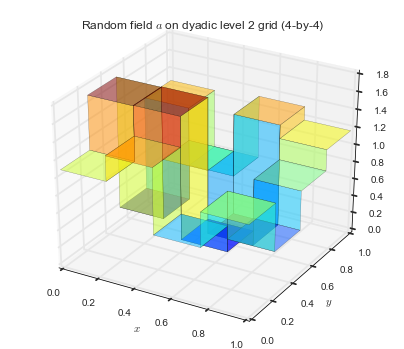

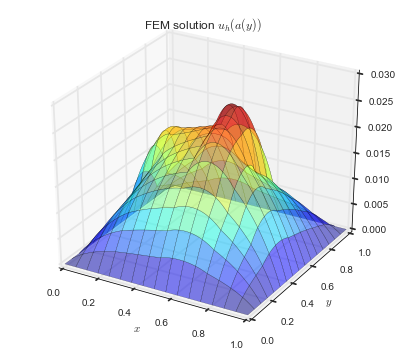

In [1]:
import numpy as np
import importlib
import dyadic_fem as df
import point_generator as pg
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
importlib.reload(df)
importlib.reload(pg)
%matplotlib inline

fem_div = 7
field_div = 2

a_bar = 1.0
c = 0.9

a = df.make_dyadic_random_field(div=field_div, a_bar=a_bar, c=c, seed=3)
fem = df.DyadicFEMSolver(div=fem_div, rand_field=a, f=1.0)
fem.solve()

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
a.plot(ax, title='Random field $a$ on dyadic level 2 grid (4-by-4)')
plt.savefig('dyadic_random_field.pdf')

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
#ax = fig.add_subplot(1, 2, 2, projection='3d')
fem.u.plot(ax, title='FEM solution $u_h(a(y))$')
plt.savefig('fem_solution.pdf')
plt.show()

### Make the measurements, and make a digram showing where they are

[]

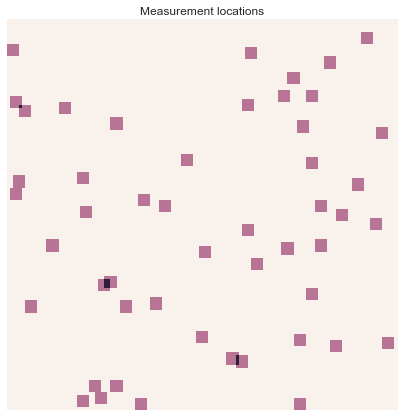

In [2]:
# local_width is the width of the measurement squares
local_width = 2**(fem_div - 5)

m = 50

# We make the ambient spaces for Wm and Vn
np.random.seed(2)
Wm, Wloc = df.make_random_local_integration_basis(m=m, div=fem_div, width=local_width, space='H1', return_map=True)
Wm = Wm.orthonormalise()

fig, ax = plt.subplots(figsize=(7,7))     
sns.heatmap(Wloc.values, xticklabels=False, yticklabels=False, cbar=False, ax=ax)
ax.set_title('Measurement locations')
#ax.set_xticks(np.linspace(0.0, 1.0, Wloc.values.shape[0]))
#ax.set_yticks(np.linspace(0.0, 1.0, Wloc.values.shape[1]))
plt.savefig('measurement_locs_50.pdf')
plt.plot()

In [3]:
#pd = pg.MonteCarlo(d=2**field_div*2**field_div, n=2000, lims=[-1, 1], seed=1)
pd = pg.QMCLatticeRule(d=2**field_div*2**field_div, n=2000, lims=[-1, 1])
#Vn_grb = df.greedy_reduced_basis_construction(n=m, field_div=field_div, fem_div=fem_div, \
#                                                    point_dictionary = pd, a_bar=a_bar, c=c, verbose=True)

In [4]:
Vn_sin = df.make_sin_basis(fem_div, N=2**(fem_div-2), space='H1')

Vn_red, Vn_red_fields = df.make_reduced_basis(n=m, field_div=field_div, fem_div=fem_div, space='H1', a_bar=a_bar, c=c)

In [5]:
sin_err = []
hat_err = []
hat_ns = []
red_err = []
#grb_err = []

ns = range(2,m,2)

for i in ns:
    Vn_sin_i = Vn_sin.subspace(slice(0,i))
    Vn_red_i = Vn_red.subspace(slice(0,i))
    #Vn_grb_i = Vn_grb.subspace(slice(0,i))
    
    sin_err.append((Vn_sin_i.project(fem.u) - fem.u).norm(space='H1'))
    red_err.append((Vn_red_i.project(fem.u) - fem.u).norm(space='H1'))
    #grb_err.append((Vn_grb_i.project(fem.u) - fem.u).norm(space='H1'))    

div_levels = [2,3,4,5]
for i, coarse_div in enumerate(div_levels):
    Vn_hat_i = df.make_hat_basis(div=coarse_div, space='H1')
    hat_err.append((Vn_hat_i.project(fem.u) - fem.u).norm(space='H1'))
    hat_ns.append(Vn_hat_i.n)

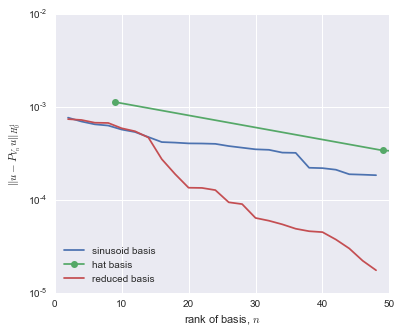

In [6]:
f, ax = plt.subplots(figsize=(6, 5))
ns = range(2,m,2)

ax.set(yscale="log")
plt.plot(ns, sin_err, label='sinusoid basis')
plt.plot(hat_ns, hat_err, label='hat basis', marker='o')
plt.plot(ns, red_err, label='reduced basis')
#plt.plot(ns, grb_err, label='greedy algorithm reduced basis') 
ax.set(xlabel='rank of basis, $n$', ylabel='$\|u - P_{V_n} u\|_{H_0^1}$')
ax.set_xlim([0, 50])
plt.legend(loc=3)
plt.savefig('projection_diffs_50.pdf')
plt.show()

## The reconstruction code

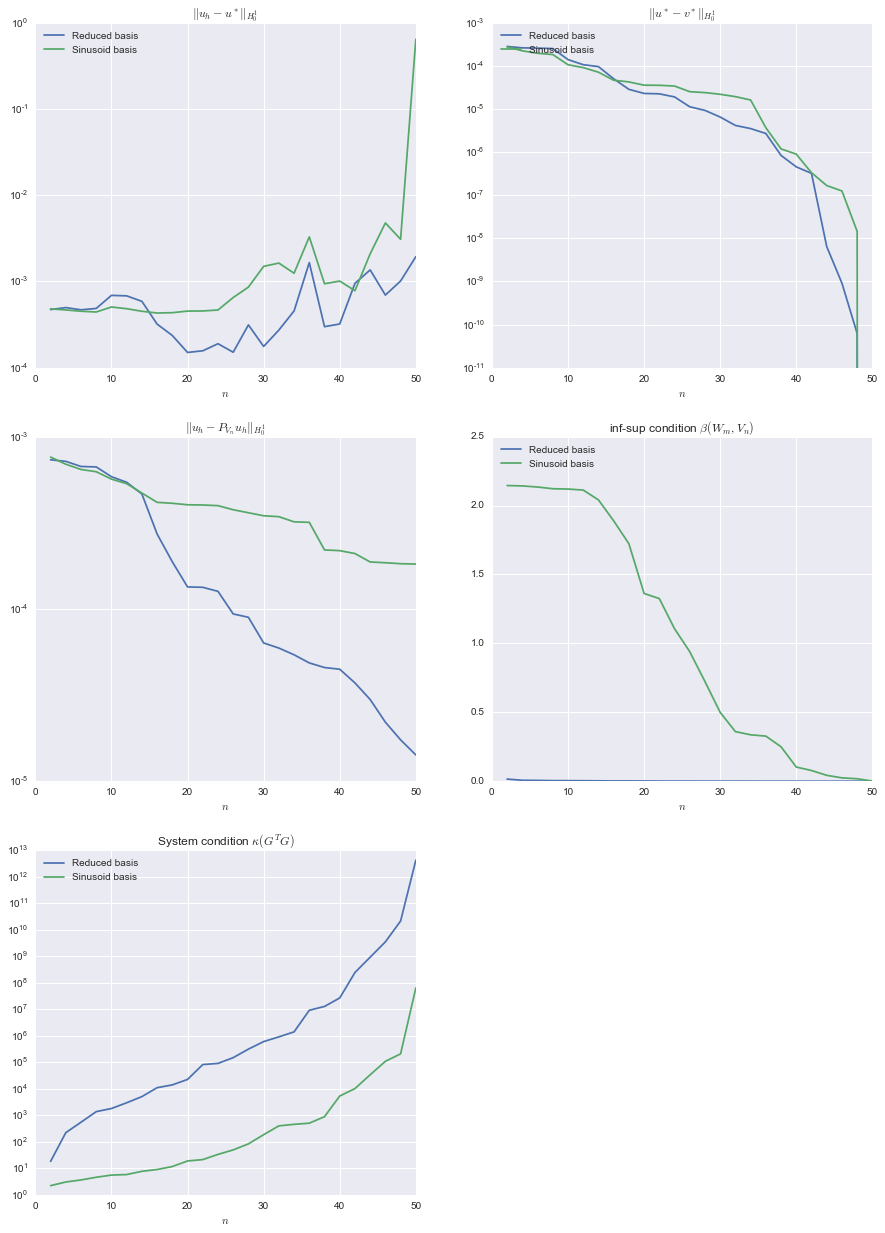

In [7]:
axs = []
fig = plt.figure(figsize=(15, 21))
axs.append(fig.add_subplot(3, 2, 1, title='$\| u_h - u^* \|_{H_0^1}$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 2, title='$\| u^* - v^* \|_{H_0^1}$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 3, title='$\| u_h - P_{V_n} u_h \|_{H_0^1}$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 4, title=r'inf-sup condition $\beta(W_m, V_n)$'))
axs[-1].set(xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 5, title=r'System condition $\kappa(G^T G)$'))
axs[-1].set(yscale="log", xlabel='$n$')

w = Wm.dot(fem.u)
u_p_w = Wm.project(fem.u)

#m_stats[0, j] = (fem.u-u_p_w).norm(space='H1')

ns = range(2, m+1, 2)
stats = np.zeros([5, 3, len(ns)])

#bases = [Vn_red, Vn_grb, Vn_sin]
#basis_labels = ['Reduced basis', 'Reduced basis from greedy algo', 'Sinusoid basis']
bases = [Vn_red, Vn_sin]
basis_labels = ['Reduced basis', 'Sinusoid basis']

for i, n in enumerate(ns):

    for j, Vn_big in enumerate(bases):
    
        Vn = Vn_big.subspace(slice(0,n))

        u_p_v = Vn.project(fem.u)
        BP = df.BasisPair(Wm, Vn)
        FB = BP.make_favorable_basis()
        u_star, v_star, w_p, v_w_p = FB.measure_and_reconstruct(fem.u)

        stats[0, j, i] = (fem.u-u_star).norm(space='H1')
        stats[1, j, i] = (u_star - v_star).norm(space='H1')
        stats[2, j, i] = FB.beta()
        stats[3, j, i] = np.linalg.cond(BP.G.T @ BP.G)
        stats[4, j, i] = (fem.u - u_p_v).norm(space='H1')
    
for j, basis_label in enumerate(basis_labels):

    axs[0].plot(ns, stats[0, j, :], label=basis_label)
    axs[0].legend(loc=2)
    axs[1].plot(ns, stats[1, j, :], label=basis_label)
    axs[1].legend(loc=2)
    axs[2].plot(ns, stats[4, j, :], label=basis_label)

    axs[3].plot(ns, stats[2, j, :], label=basis_label)
    axs[3].legend(loc=2)
    axs[4].plot(ns, stats[3, j, :], label=basis_label)
    axs[4].legend(loc=2)

    
plt.show()

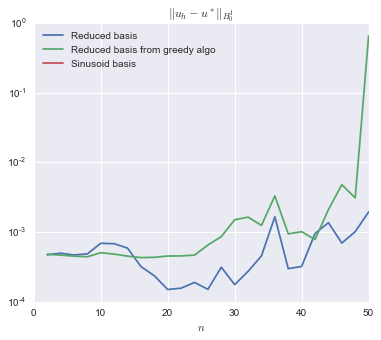

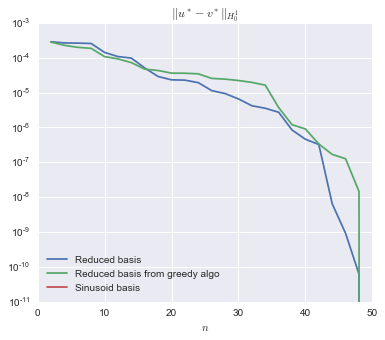

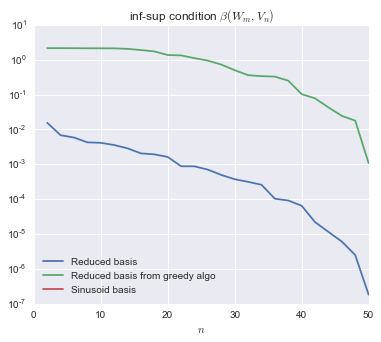

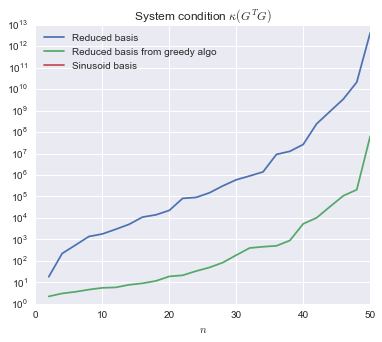

In [8]:

fig1, ax1 = plt.subplots(figsize=(6,5))
ax1.set(title='$\| u_h - u^* \|_{H_0^1}$')
ax1.set(yscale="log", xlabel='$n$')

fig2, ax2 = plt.subplots(figsize=(6,5))
ax2.set(title='$\| u^* - v^* \|_{H_0^1}$')
ax2.set(yscale="log", xlabel='$n$')

#fig3, ax3 = plt.subplots(figsize=(6,5), title='$\| u_h - P_{V_n} u_h \|_{H_0^1}$'))
#ax3.set(yscale="log", xlabel='$n$')

fig4, ax4 = plt.subplots(figsize=(6,5))
ax4.set(title=r'inf-sup condition $\beta(W_m, V_n)$')
ax4.set(yscale='log', xlabel='$n$')

fig5, ax5 = plt.subplots(figsize=(6,5))
ax5.set(title=r'System condition $\kappa(G^T G)$')
ax5.set(yscale="log", xlabel='$n$')

ns = range(2, m+1, 2)
basis_labels = ['Reduced basis', 'Reduced basis from greedy algo', 'Sinusoid basis']

for j, basis_label in enumerate(basis_labels):

    ax1.plot(ns, stats[0, j, :], label=basis_label)
    ax1.legend(loc=2)
    
    fig1.savefig('reconstruction_error_50.pdf')
    
    ax2.plot(ns, stats[1, j, :], label=basis_label)
    ax2.legend(loc=3)
    fig2.savefig('u_star_v_star_diff_50.pdf')

    ax4.plot(ns, stats[2, j, :], label=basis_label)
    ax4.legend(loc=3)
    fig4.savefig('inf_sup_cond_50.pdf')
    
    ax5.plot(ns, stats[3, j, :], label=basis_label)
    ax5.legend(loc=2)
    fig5.savefig('system_cond_number_50.pdf')

    
plt.show()

## We experiment with only have points in the upper left corner

[]

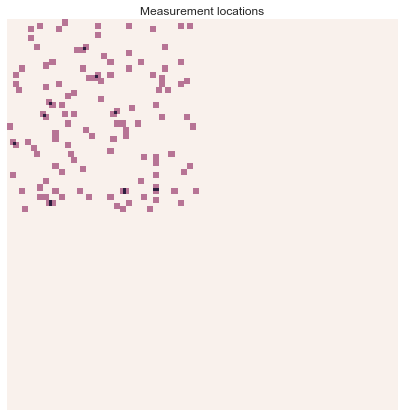

In [9]:
# local_width is the width of the measurement squares
local_width = 2**(fem_div - 6)

m = 120

# We make the ambient spaces for Wm and Vn
np.random.seed(2)

# we make a bounding box to be the quarter square
side_n = 2**fem_div-1
bounding_box = np.array([[0, 2**(fem_div-1)], [0, 2**(fem_div-1)]])

Wm, Wloc = df.make_random_local_integration_basis(m=m, div=fem_div, width=local_width, bounds=bounding_box, space='H1', return_map=True)
Wm = Wm.orthonormalise()

fig, ax = plt.subplots(figsize=(7,7))     
sns.heatmap(Wloc.values, xticklabels=False, yticklabels=False, cbar=False, ax=ax)
ax.set_title('Measurement locations')
#ax.set_xticks(np.linspace(0.0, 1.0, Wloc.values.shape[0]))
#ax.set_yticks(np.linspace(0.0, 1.0, Wloc.values.shape[1]))
plt.savefig('measurement_locs_120.pdf')
plt.plot()

In [10]:
#pd = pg.MonteCarlo(d=2**field_div*2**field_div, n=2000, lims=[-1, 1], seed=1)
pd = pg.QMCLatticeRule(d=2**field_div*2**field_div, n=5000, lims=[-1, 1])
#Vn_grb = df.greedy_reduced_basis_construction(n=m, field_div=field_div, fem_div=fem_div, \
#                                                    point_dictionary = pd, a_bar=a_bar, c=c, verbose=True)

Vn_sin = df.make_sin_basis(fem_div, N=2**(fem_div-2), space='H1')
Vn_red, Vn_red_fields = df.make_reduced_basis(n=m, field_div=field_div, fem_div=fem_div, space='H1', a_bar=a_bar, c=c)

In [14]:
sin_err = []
hat_err = []
hat_ns = []
red_err = []
grb_err = []

ns = range(2,m+1,2)

for i in ns:
    Vn_sin_i = Vn_sin.subspace(slice(0,i))
    Vn_red_i = Vn_red.subspace(slice(0,i))
    #Vn_grb_i = Vn_grb.subspace(slice(0,i))
    
    sin_err.append((Vn_sin_i.project(fem.u) - fem.u).norm(space='H1'))
    red_err.append((Vn_red_i.project(fem.u) - fem.u).norm(space='H1'))
    #grb_err.append((Vn_grb_i.project(fem.u) - fem.u).norm(space='H1'))    

div_levels = [2,3,4,5]
for i, coarse_div in enumerate(div_levels):
    Vn_hat_i = df.make_hat_basis(div=coarse_div, space='H1')
    hat_err.append((Vn_hat_i.project(fem.u) - fem.u).norm(space='H1'))
    hat_ns.append(Vn_hat_i.n)

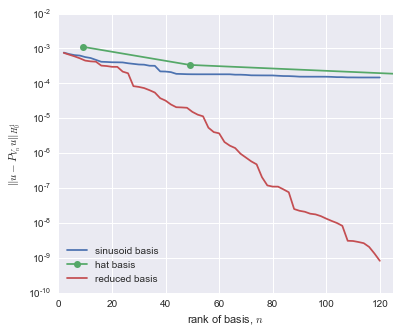

In [16]:
f, ax = plt.subplots(figsize=(6, 5))

ax.set(yscale="log")
plt.plot(ns, sin_err, label='sinusoid basis')
plt.plot(hat_ns, hat_err, label='hat basis', marker='o')
plt.plot(ns, red_err, label='reduced basis')
#plt.plot(ns, grb_err, label='greedy algorithm reduced basis') 
ax.set(xlabel='rank of basis, $n$', ylabel='$\|u - P_{V_n} u\|_{H_0^1}$')
ax.set_xlim([0, 125])
plt.legend(loc=3)
plt.savefig('projection_diffs_120.pdf')
plt.show()

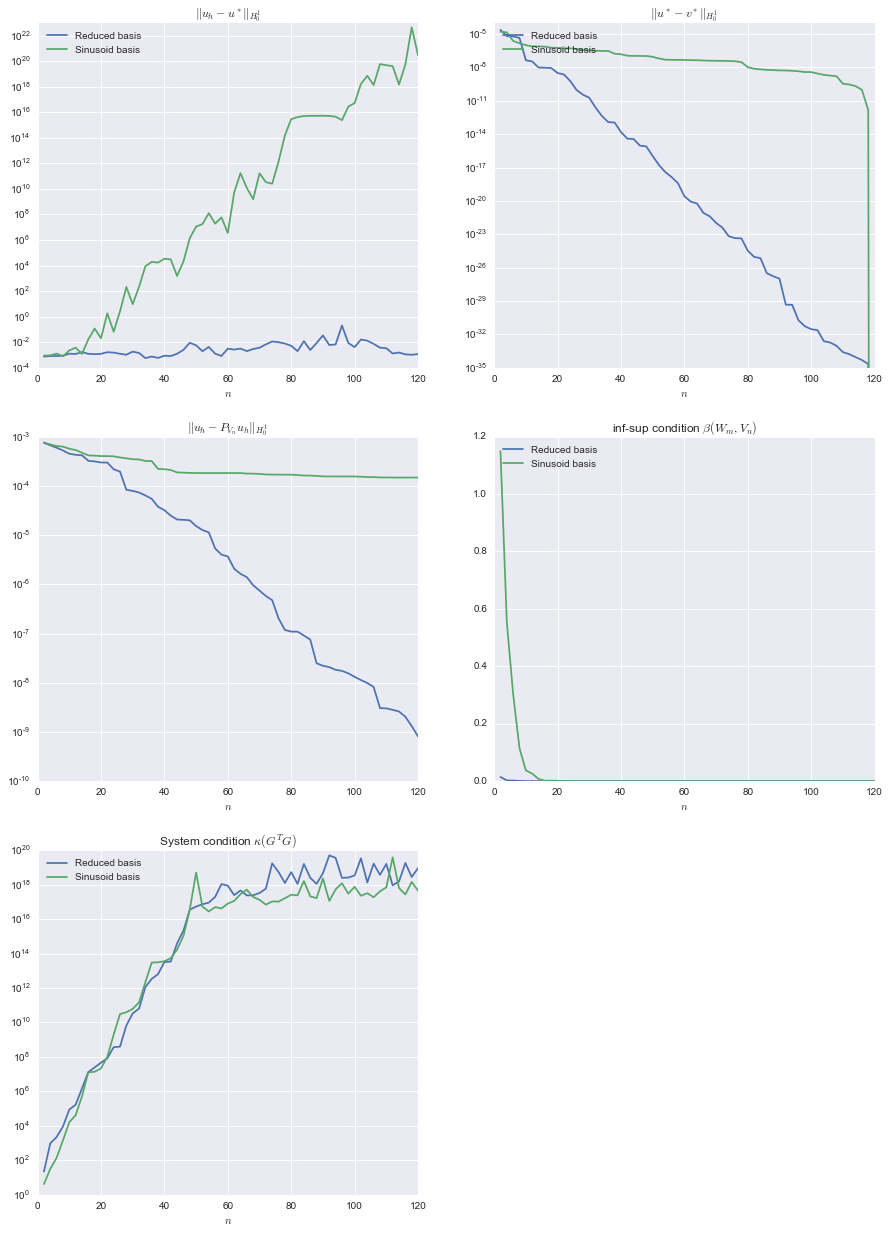

In [17]:
axs = []
fig = plt.figure(figsize=(15, 21))
axs.append(fig.add_subplot(3, 2, 1, title='$\| u_h - u^* \|_{H_0^1}$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 2, title='$\| u^* - v^* \|_{H_0^1}$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 3, title='$\| u_h - P_{V_n} u_h \|_{H_0^1}$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 4, title=r'inf-sup condition $\beta(W_m, V_n)$'))
axs[-1].set(xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 5, title=r'System condition $\kappa(G^T G)$'))
axs[-1].set(yscale="log", xlabel='$n$')

w = Wm.dot(fem.u)
u_p_w = Wm.project(fem.u)

#m_stats[0, j] = (fem.u-u_p_w).norm(space='H1')

ns = range(2, m+1, 2)
stats = np.zeros([5, 3, len(ns)])

#bases = [Vn_red, Vn_grb, Vn_sin]
bases = [Vn_red, Vn_sin]
#basis_labels = ['Reduced basis', 'Reduced basis from greedy algo', 'Sinusoid basis']
basis_labels = ['Reduced basis', 'Sinusoid basis']

for i, n in enumerate(ns):

    for j, Vn_big in enumerate(bases):
    
        Vn = Vn_big.subspace(slice(0,n))

        u_p_v = Vn.project(fem.u)
        BP = df.BasisPair(Wm, Vn)
        FB = BP.make_favorable_basis()
        u_star, v_star, w_p, v_w_p = FB.measure_and_reconstruct(fem.u)

        stats[0, j, i] = (fem.u-u_star).norm(space='H1')
        stats[1, j, i] = (u_star - v_star).norm(space='H1')
        stats[2, j, i] = FB.beta()
        stats[3, j, i] = np.linalg.cond(BP.G.T @ BP.G)
        stats[4, j, i] = (fem.u - u_p_v).norm(space='H1')
    
for j, basis_label in enumerate(basis_labels):

    axs[0].plot(ns, stats[0, j, :], label=basis_label)
    axs[0].legend(loc=2)
    axs[1].plot(ns, stats[1, j, :], label=basis_label)
    axs[1].legend(loc=2)
    axs[2].plot(ns, stats[4, j, :], label=basis_label)

    axs[3].plot(ns, stats[2, j, :], label=basis_label)
    axs[3].legend(loc=2)
    axs[4].plot(ns, stats[3, j, :], label=basis_label)
    axs[4].legend(loc=2)

    
plt.show()

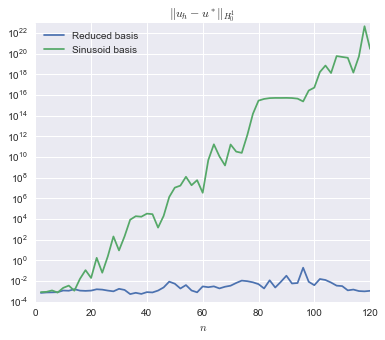

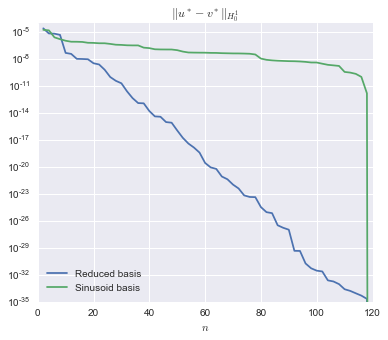

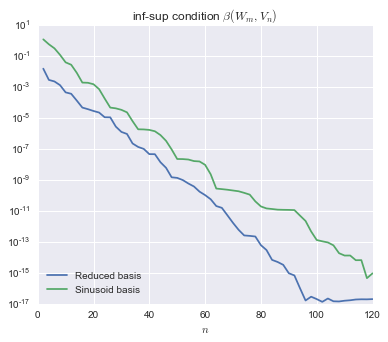

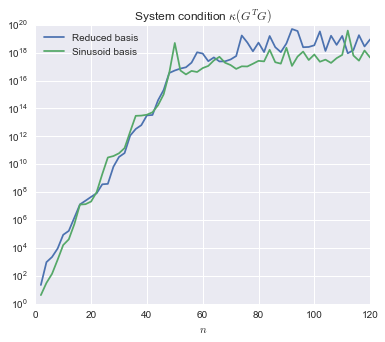

In [19]:

fig1, ax1 = plt.subplots(figsize=(6,5))
ax1.set(title='$\| u_h - u^* \|_{H_0^1}$')
ax1.set(yscale="log", xlabel='$n$')

fig2, ax2 = plt.subplots(figsize=(6,5))
ax2.set(title='$\| u^* - v^* \|_{H_0^1}$')
ax2.set(yscale="log", xlabel='$n$')

#fig3, ax3 = plt.subplots(figsize=(6,5), title='$\| u_h - P_{V_n} u_h \|_{H_0^1}$'))
#ax3.set(yscale="log", xlabel='$n$')

fig4, ax4 = plt.subplots(figsize=(6,5))
ax4.set(title=r'inf-sup condition $\beta(W_m, V_n)$')
ax4.set(yscale='log', xlabel='$n$')

fig5, ax5 = plt.subplots(figsize=(6,5))
ax5.set(title=r'System condition $\kappa(G^T G)$')
ax5.set(yscale="log", xlabel='$n$')

ns = range(2, m+1, 2)
#basis_labels = ['Reduced basis', 'Reduced basis from greedy algo', 'Sinusoid basis']
basis_labels = ['Reduced basis', 'Sinusoid basis']

for j, basis_label in enumerate(basis_labels):

    ax1.plot(ns, stats[0, j, :], label=basis_label)
    ax1.legend(loc=2)
    
    fig1.savefig('reconstruction_error_120.pdf')
    
    ax2.plot(ns, stats[1, j, :], label=basis_label)
    ax2.legend(loc=3)
    fig2.savefig('u_star_v_star_diff_120.pdf')

    ax4.plot(ns, stats[2, j, :], label=basis_label)
    ax4.legend(loc=3)
    fig4.savefig('inf_sup_cond_120.pdf')
    
    ax5.plot(ns, stats[3, j, :], label=basis_label)
    ax5.legend(loc=2)
    fig5.savefig('system_cond_number_120.pdf')

    
plt.show()

## Now with 3/4 of all points in the upper left corner, rest evenly in the remaining space

[]

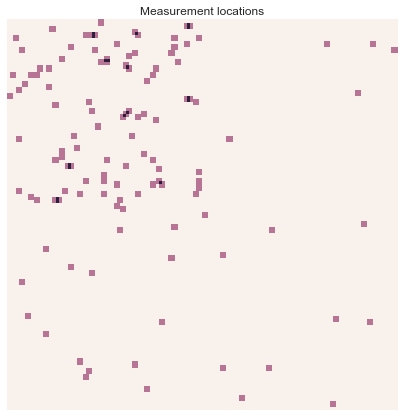

In [3]:
# local_width is the width of the measurement squares
local_width = 2**(fem_div - 6)

m = 120

# We make the ambient spaces for Wm and Vn
np.random.seed(2)

# we make a bounding box to be the quarter square
side_n = 2**fem_div-1
bounding_box = np.array([[0, 2**(fem_div-1)], [0, 2**(fem_div-1)]])

Wm_qrtr, Wloc_qrtr = df.make_random_local_integration_basis(m=m, div=fem_div, width=local_width, \
                                                            bounds=bounding_box, bound_prop=0.75, space='H1', return_map=True)
Wm = Wm_qrtr.orthonormalise()

fig, ax = plt.subplots(figsize=(7,7))     
sns.heatmap(Wloc_qrtr.values, xticklabels=False, yticklabels=False, cbar=False, ax=ax)
ax.set_title('Measurement locations')
#ax.set_xticks(np.linspace(0.0, 1.0, Wloc.values.shape[0]))
#ax.set_yticks(np.linspace(0.0, 1.0, Wloc.values.shape[1]))
plt.savefig('measurement_locs_120_qrtr_mixed.pdf')
plt.plot()

In [4]:
#pd = pg.MonteCarlo(d=2**field_div*2**field_div, n=2000, lims=[-1, 1], seed=1)
pd = pg.QMCLatticeRule(d=2**field_div*2**field_div, n=5000, lims=[-1, 1])
#Vn_grb = df.greedy_reduced_basis_construction(n=m, field_div=field_div, fem_div=fem_div, \
#                                                    point_dictionary = pd, a_bar=a_bar, c=c, verbose=True)

Vn_sin = df.make_sin_basis(fem_div, N=2**(fem_div-2), space='H1')
Vn_red, Vn_red_fields = df.make_reduced_basis(n=m, field_div=field_div, fem_div=fem_div, space='H1', a_bar=a_bar, c=c)

In [5]:
sin_err = []
hat_err = []
hat_ns = []
red_err = []
grb_err = []

ns = range(2,m+1,2)

for i in ns:
    Vn_sin_i = Vn_sin.subspace(slice(0,i))
    Vn_red_i = Vn_red.subspace(slice(0,i))
    #Vn_grb_i = Vn_grb.subspace(slice(0,i))
    
    sin_err.append((Vn_sin_i.project(fem.u) - fem.u).norm(space='H1'))
    red_err.append((Vn_red_i.project(fem.u) - fem.u).norm(space='H1'))
    #grb_err.append((Vn_grb_i.project(fem.u) - fem.u).norm(space='H1'))    

div_levels = [2,3,4,5]
for i, coarse_div in enumerate(div_levels):
    Vn_hat_i = df.make_hat_basis(div=coarse_div, space='H1')
    hat_err.append((Vn_hat_i.project(fem.u) - fem.u).norm(space='H1'))
    hat_ns.append(Vn_hat_i.n)

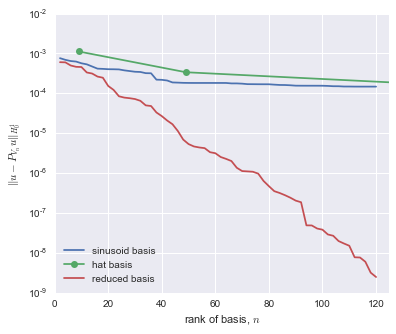

In [6]:
f, ax = plt.subplots(figsize=(6, 5))

ax.set(yscale="log")
plt.plot(ns, sin_err, label='sinusoid basis')
plt.plot(hat_ns, hat_err, label='hat basis', marker='o')
plt.plot(ns, red_err, label='reduced basis')
#plt.plot(ns, grb_err, label='greedy algorithm reduced basis') 
ax.set(xlabel='rank of basis, $n$', ylabel='$\|u - P_{V_n} u\|_{H_0^1}$')
ax.set_xlim([0, 125])
plt.legend(loc=3)
plt.savefig('projection_diffs_120_qrtr_mixed.pdf')
plt.show()

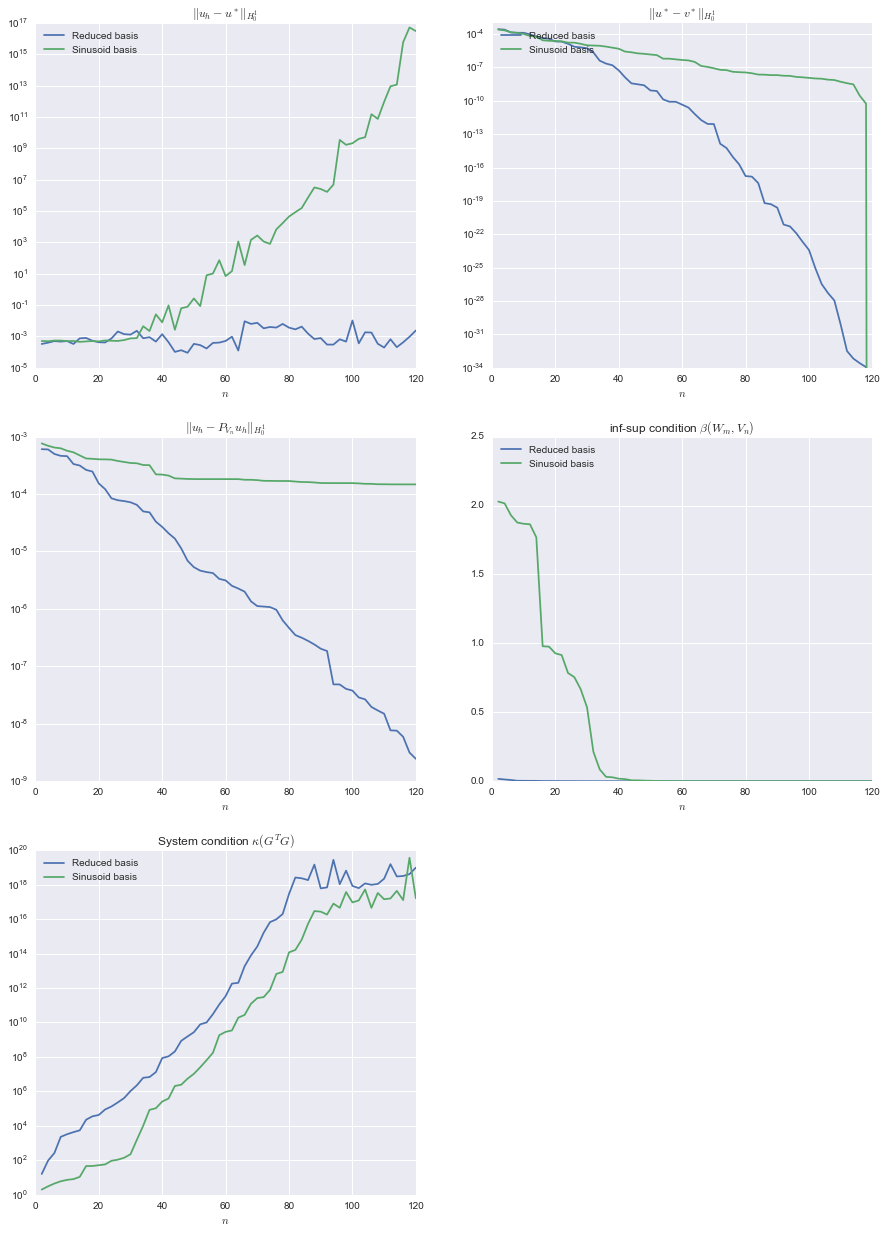

In [9]:
axs = []
fig = plt.figure(figsize=(15, 21))
axs.append(fig.add_subplot(3, 2, 1, title='$\| u_h - u^* \|_{H_0^1}$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 2, title='$\| u^* - v^* \|_{H_0^1}$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 3, title='$\| u_h - P_{V_n} u_h \|_{H_0^1}$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 4, title=r'inf-sup condition $\beta(W_m, V_n)$'))
axs[-1].set(xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 5, title=r'System condition $\kappa(G^T G)$'))
axs[-1].set(yscale="log", xlabel='$n$')

w = Wm.dot(fem.u)
u_p_w = Wm.project(fem.u)

#m_stats[0, j] = (fem.u-u_p_w).norm(space='H1')

ns = range(2, m+1, 2)
stats = np.zeros([5, 3, len(ns)])

#bases = [Vn_red, Vn_grb, Vn_sin]
bases = [Vn_red, Vn_sin]
#basis_labels = ['Reduced basis', 'Reduced basis from greedy algo', 'Sinusoid basis']
basis_labels = ['Reduced basis', 'Sinusoid basis']

for i, n in enumerate(ns):

    for j, Vn_big in enumerate(bases):
    
        Vn = Vn_big.subspace(slice(0,n))

        u_p_v = Vn.project(fem.u)
        BP = df.BasisPair(Wm, Vn)
        FB = BP.make_favorable_basis()
        u_star, v_star, w_p, v_w_p = FB.measure_and_reconstruct(fem.u)

        stats[0, j, i] = (fem.u-u_star).norm(space='H1')
        stats[1, j, i] = (u_star - v_star).norm(space='H1')
        stats[2, j, i] = FB.beta()
        stats[3, j, i] = np.linalg.cond(BP.G.T @ BP.G)
        stats[4, j, i] = (fem.u - u_p_v).norm(space='H1')
    
for j, basis_label in enumerate(basis_labels):

    axs[0].plot(ns, stats[0, j, :], label=basis_label)
    axs[0].legend(loc=2)
    axs[1].plot(ns, stats[1, j, :], label=basis_label)
    axs[1].legend(loc=2)
    axs[2].plot(ns, stats[4, j, :], label=basis_label)

    axs[3].plot(ns, stats[2, j, :], label=basis_label)
    axs[3].legend(loc=2)
    axs[4].plot(ns, stats[3, j, :], label=basis_label)
    axs[4].legend(loc=2)

    
plt.show()

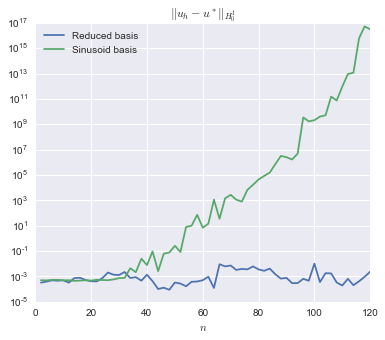

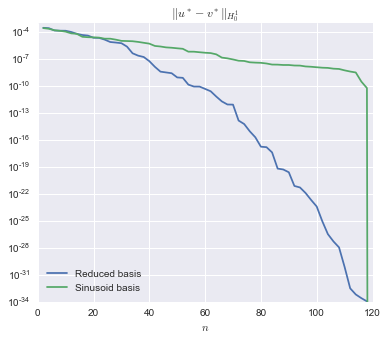

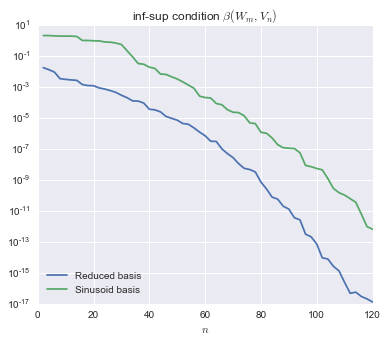

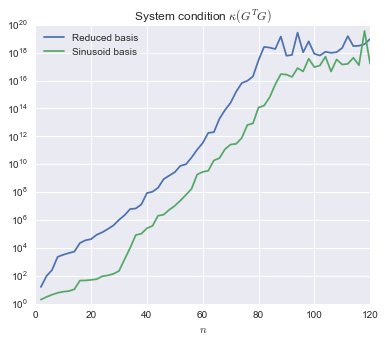

In [10]:

fig1, ax1 = plt.subplots(figsize=(6,5))
ax1.set(title='$\| u_h - u^* \|_{H_0^1}$')
ax1.set(yscale="log", xlabel='$n$')

fig2, ax2 = plt.subplots(figsize=(6,5))
ax2.set(title='$\| u^* - v^* \|_{H_0^1}$')
ax2.set(yscale="log", xlabel='$n$')

#fig3, ax3 = plt.subplots(figsize=(6,5), title='$\| u_h - P_{V_n} u_h \|_{H_0^1}$'))
#ax3.set(yscale="log", xlabel='$n$')

fig4, ax4 = plt.subplots(figsize=(6,5))
ax4.set(title=r'inf-sup condition $\beta(W_m, V_n)$')
ax4.set(yscale='log', xlabel='$n$')

fig5, ax5 = plt.subplots(figsize=(6,5))
ax5.set(title=r'System condition $\kappa(G^T G)$')
ax5.set(yscale="log", xlabel='$n$')

ns = range(2, m+1, 2)
#basis_labels = ['Reduced basis', 'Reduced basis from greedy algo', 'Sinusoid basis']
basis_labels = ['Reduced basis', 'Sinusoid basis']

for j, basis_label in enumerate(basis_labels):

    ax1.plot(ns, stats[0, j, :], label=basis_label)
    ax1.legend(loc=2)
    
    fig1.savefig('reconstruction_error_120_qrtr_mixed.pdf')
    
    ax2.plot(ns, stats[1, j, :], label=basis_label)
    ax2.legend(loc=3)
    fig2.savefig('u_star_v_star_diff_120_qrtr_mixed.pdf')

    ax4.plot(ns, stats[2, j, :], label=basis_label)
    ax4.legend(loc=3)
    fig4.savefig('inf_sup_cond_120_qrtr_mixed.pdf')
    
    ax5.plot(ns, stats[3, j, :], label=basis_label)
    ax5.legend(loc=2)
    fig5.savefig('system_cond_number_120_qrtr_mixed.pdf')
